In [2]:
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
path = "youtube_comments_climate_change/cleaned_data.csv"
data = pd.read_csv(path, sep=",", encoding='utf-8')

list(data.columns)

['Unnamed: 0', 'publishedAt', 'authorName', 'text', 'isReply', 'cleaned']

### Loading the model

In [9]:
import tensorflow as tf
import tensorflow_hub as hub

hub_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
embed = hub.load(hub_url)
embeddings = embed(data['cleaned'])

print(embeddings)
print("The embeddings vector is of fixed length {}".format(embeddings.shape[1]))

tf.Tensor(
[[ 0.02267956 -0.06716511  0.01718922 ... -0.0158857  -0.043926
  -0.00393031]
 [ 0.04192     0.07056528  0.09499479 ... -0.03520851 -0.0134883
   0.04670066]
 [-0.06692986 -0.00541758 -0.03079402 ...  0.02694076 -0.01263959
  -0.07979716]
 ...
 [-0.01887087  0.06309655  0.1051517  ... -0.01325584 -0.04266983
   0.01906748]
 [ 0.01090654 -0.08720968 -0.00068635 ...  0.00569523 -0.01905336
  -0.04718436]
 [ 0.0252452  -0.01673799 -0.06606335 ... -0.00096804 -0.04874956
  -0.04058736]], shape=(25914, 512), dtype=float32)
The embeddings vector is of fixed length 512


In [10]:
np.save('embeddings.npy', embeddings, allow_pickle=True, fix_imports=True)
data.to_pickle('data.pkl')

In [4]:
embeddings = np.load('embeddings.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')
data = pd.read_pickle('data.pkl')

#### Normalizing vectors

In [5]:
from sklearn.preprocessing import normalize
_normalize =True


if (_normalize):
  embeddings = normalize(embeddings, norm='l2')

### Load embeddings into embeddings projector

In [68]:
np.savetxt("emebddings.tsv", embeddings, delimiter="\t")

Once for "\t" and once for "\n"

In [88]:
for i, row in data.iterrows():
    if "\n" in data['text'][i]:
        text = data['text'][i]
        data.at[i,'text'] = text.replace("\n", " ")

In [89]:
data['text'][17]

'Are you serious? The earth is going to do its thing regardless of if it is warming or cooling. What happens to people on the other hand, will change drastically over time if things were to go to one extreme or the other. Many people say that less people would actually be better for "the earth".  '

In [90]:
import csv

pd.DataFrame(data['text']).to_csv('metadata.tsv',sep='\t', quoting=csv.QUOTE_NONE)

## Dimensionality reduction

### PCA

#### Choosing dimensions by looking at cumulative explained variance ration

95% cut-off threshold reached with 217 components.


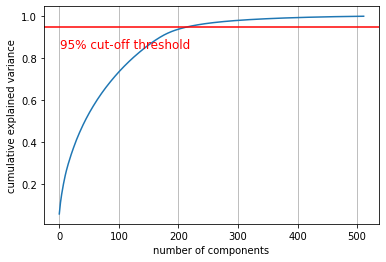

In [16]:
pca_cev = PCA().fit(embeddings)
cev_plot = np.cumsum(pca_cev.explained_variance_ratio_)
plt.plot(cev_plot)
plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=12)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.grid(axis='x')

print("95% cut-off threshold reached with {} components.".format(np.argwhere(cev_plot >= 0.95)[0][0]))

In [6]:
SUBSPACE_DIM = 217

pca = PCA(n_components= SUBSPACE_DIM)
pca_embeddings = pca.fit_transform(embeddings)

print("Dimensions of embeddings matrix after PCA: ({}, {})".format(pca_embeddings.shape[0], pca_embeddings.shape[1]))

Dimensions of embeddings matrix after PCA: (25914, 217)


### SVD

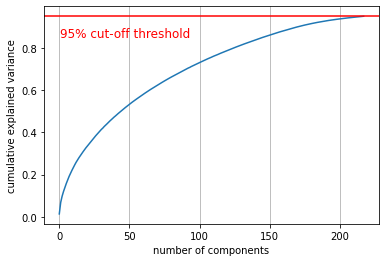

In [50]:
svd_plot = []
for i in range(1,512):
    svd_cev = TruncatedSVD(n_components=i).fit(embeddings)
    sum = svd_cev.explained_variance_ratio_.sum()
    svd_plot.append(sum)
    if sum >= 0.95:
        break


plt.plot(svd_plot)
plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=12)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.grid(axis='x')

In [7]:
SUBSPACE_DIM = 217

svd = TruncatedSVD(n_components= SUBSPACE_DIM)
svd_embeddings = svd.fit_transform(embeddings)

print("Dimensions of embeddings matrix after PCA: ({}, {})".format(svd_embeddings.shape[0], svd_embeddings.shape[1]))

Dimensions of embeddings matrix after PCA: (25914, 217)


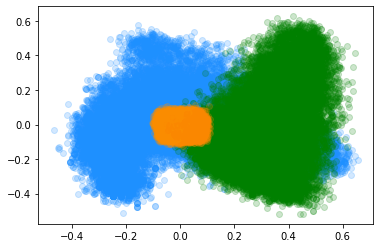

In [8]:
plt.scatter(pca_embeddings[:, 0], pca_embeddings[:, 1], color = "dodgerblue", alpha=0.2)
plt.scatter(svd_embeddings[:, 0], svd_embeddings[:, 1], color = "green", alpha=0.2)
plt.scatter(embeddings[:, 0], embeddings[:, 1], color = "darkorange", alpha=0.2)

### Evaluating an optimal number of clusters

In [30]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_pca = sc.fit_transform(pca_embeddings) #ehemals X_normalized
X_svd = sc.fit_transform(svd_embeddings)

In [20]:
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans

sse_pca, sse_svd, db_pca, db_svd, slc_pca, slc_svd = {}, {}, {}, {}, {}, {}
for k in range(5, 105, 5):
    kmeans_svd = KMeans(n_clusters = k, max_iter=1000, random_state=10).fit(X_svd)
    kmeans_pca = KMeans(n_clusters = k, max_iter=1000, random_state=10).fit(X_pca)
    clusters_pca = kmeans_pca.labels_
    clusters_svd = kmeans_svd.labels_
    sse_pca[k] = kmeans_pca.inertia_
    sse_svd[k] = kmeans_svd.inertia_
    db_pca[k] = davies_bouldin_score(X_pca, clusters_pca)
    db_svd[k] = davies_bouldin_score(X_svd, clusters_svd)
    slc_pca[k] = silhouette_score(X_pca, clusters_pca)
    slc_svd[k] = silhouette_score(X_svd, clusters_svd)

#### Elbow Method

In [64]:
plt.plot(list(sse_pca.keys()), list(sse_pca.values()), color= "red")
plt.plot(list(sse_svd.keys()), list(sse_svd.values()), color= "blue")
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.show()

NameError: name 'sse_pca' is not defined

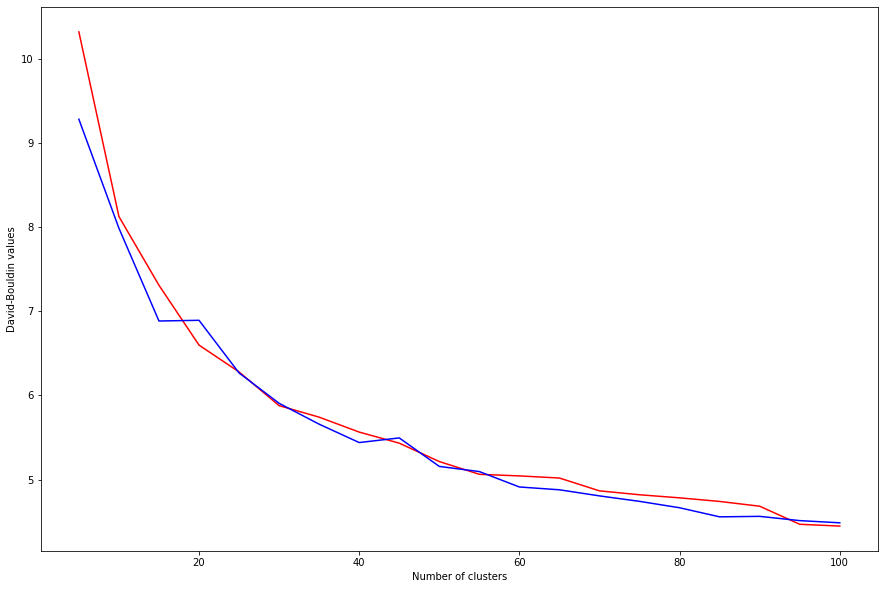

In [22]:
plt.figure(figsize=(15,10))
plt.plot(list(db_pca.keys()), list(db_pca.values()), color="red")
plt.plot(list(db_svd.keys()), list(db_svd.values()), color="blue")
plt.xlabel("Number of clusters")
plt.ylabel("David-Bouldin values")
plt.show()

#### Silhouette Score

A Silhouette Score ranges between -1 to 1. A high score means that comments are well matched to their own cluster and poorly matched to their neighborhood clusters. 

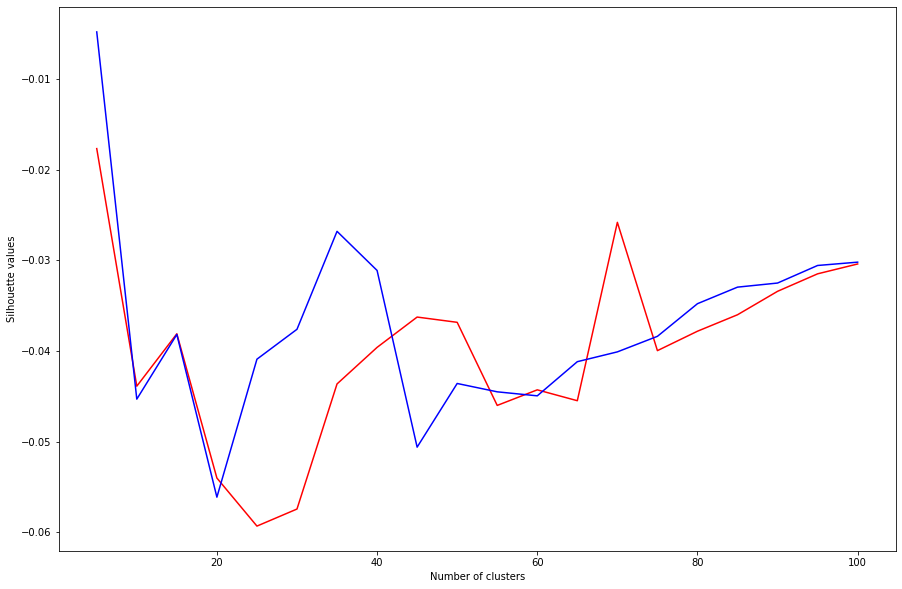

In [53]:
plt.figure(figsize=(15,10))
plt.plot(list(slc_pca.keys()), list(slc_pca.values()), color="red")
plt.plot(list(slc_svd.keys()), list(slc_svd.values()), color="blue")

plt.xlabel("Number of clusters")
plt.ylabel("Silhouette values")
plt.show()

### UMAP

In [31]:
import umap
reducer2 = umap.UMAP(n_components = 2,min_dist = .5)

embeddings_umap2 = reducer2.fit_transform(pca_embeddings)
embeddings_umap2.shape

(25914, 2)

### T-SNE

In [7]:
embeddings_tsne = TSNE(n_components=2).fit_transform(pca_embeddings)
embeddings_tsne.shape

(25914, 2)

## Calculating distance matrix

In [15]:
import numpy as np
from sklearn.metrics.pairwise import cosine_distances

def cos_sim(input_vectors):
    similarity = cosine_distances(input_vectors)
    return similarity

cosine_similarity_matrix = cos_sim(np.array(embeddings_tsne))
print(cosine_similarity_matrix)

[[0.0000000e+00 1.1753191e+00 4.3043500e-01 ... 1.1746904e+00
  5.4399550e-01 5.2419007e-02]
 [1.1753191e+00 0.0000000e+00 1.9090712e+00 ... 1.7881393e-07
  1.9561393e+00 1.4806960e+00]
 [4.3043500e-01 1.9090712e+00 0.0000000e+00 ... 1.9088051e+00
  8.7621808e-03 1.9766617e-01]
 ...
 [1.1746904e+00 1.7881393e-07 1.9088051e+00 ... 0.0000000e+00
  1.9559522e+00 1.4801359e+00]
 [5.4399550e-01 1.9561393e+00 8.7621808e-03 ... 1.9559522e+00
  0.0000000e+00 2.8353691e-01]
 [5.2419007e-02 1.4806960e+00 1.9766617e-01 ... 1.4801359e+00
  2.8353691e-01 0.0000000e+00]]


In [16]:
cosine_similarity_matrix.shape

(25914, 25914)

## Clustering with DBSCAN

TODO: takes forevvvverrr

### Choosing eps parameter


In [ ]:
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=100) # results remain roughly the same with n_neighbors<100
nbrs = neigh.fit(cosine_similarity_matrix)
distances, indices = nbrs.kneighbors(cosine_similarity_matrix)

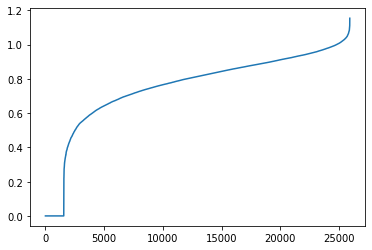

In [8]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

DBSCAN Parameter:
- eps: Max distance between two samples for them to be considered as in a neigborhood, default=0.5
- min_samples: Number of samples in a neighborhood for a point to be considered a core point, default = 5
- metric: Metric for calculating distance between instances in a feature array
- n_jobs: Used for parallelization, None means 1, -1 means using all processors

In [17]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.8, min_samples=100, metric="precomputed").fit(cosine_similarity_matrix)

In [18]:
db

DBSCAN(eps=0.8, metric='precomputed', min_samples=100)

In [19]:
components = db.components_
labels = db.labels_
core_sample_indices = db.core_sample_indices_

In [20]:
labels
(unique, counts) = np.unique(labels, return_counts=True)
frequencies = np.asarray((unique, counts)).T

In [21]:
data["labels"] = labels

From docs: Cluster labels for each point in the dataset given to fit(). Noisy samples are given the label -1.

In [23]:
frequencies

array([[    0, 25914]])

Text(0.5, 0.98, 'Clustering with DBSCAN')

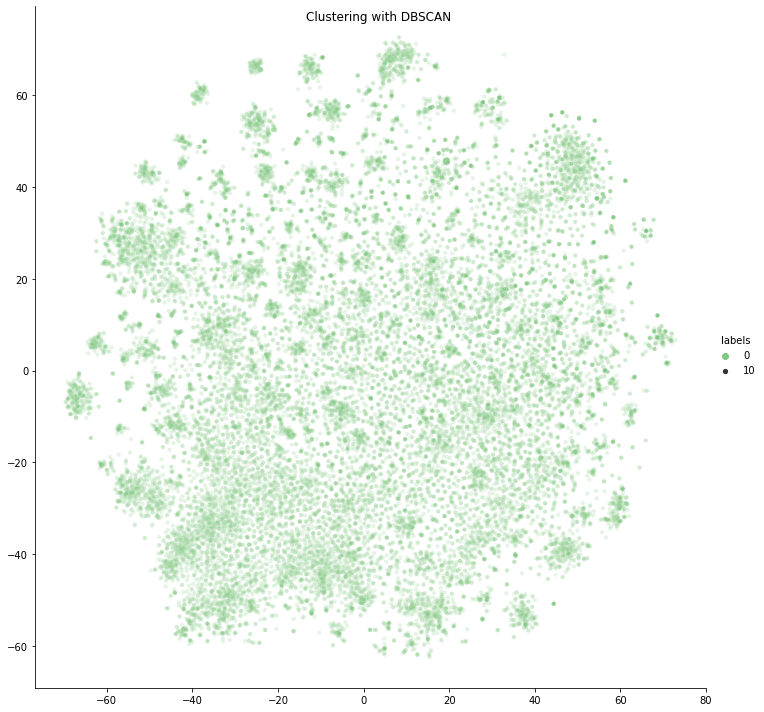

In [25]:
import seaborn as sns

palette_param = "Accent"
alpha_param = 0.2

plot = sns.relplot(x = embeddings_tsne[:, 0], y = embeddings_tsne[:, 1], size = 10, hue = data["labels"], palette = palette_param,alpha = alpha_param,height = 10)
plot.fig.suptitle('Clustering with DBSCAN')

## Clustering HDBSCAN

Crashes with metric = precomputed 

In [44]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=100)
cluster_labels = clusterer.fit_predict(embeddings_umap2)

In [45]:
data['labels_hdbscan'] = cluster_labels

In [16]:
(unique, counts) = np.unique(cluster_labels, return_counts=True)
frequencies = np.asarray((unique, counts)).T

In [23]:
frequencies_chart= frequencies[frequencies[:,0].argsort()]

<BarContainer object of 429 artists>

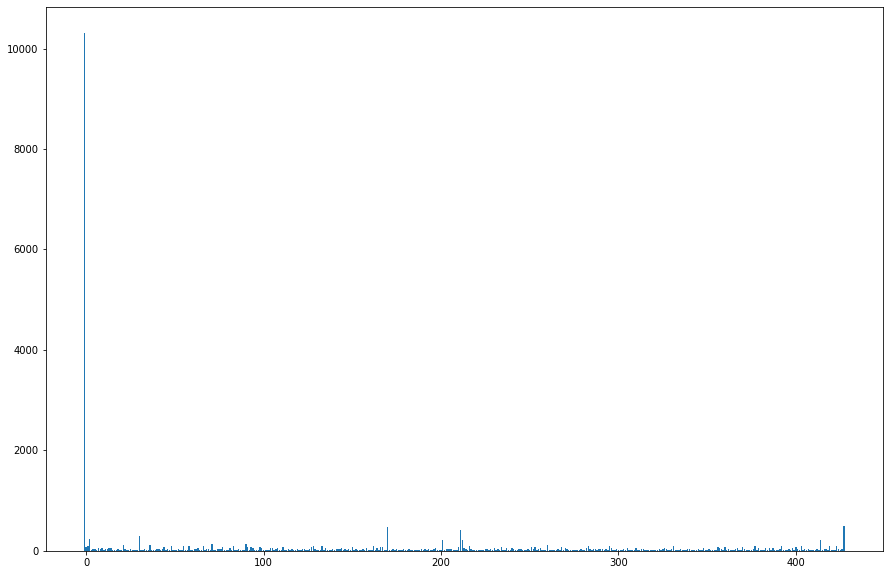

In [29]:
plt.figure(figsize=(15,10))
plt.bar(frequencies[:,0], frequencies[:,1])

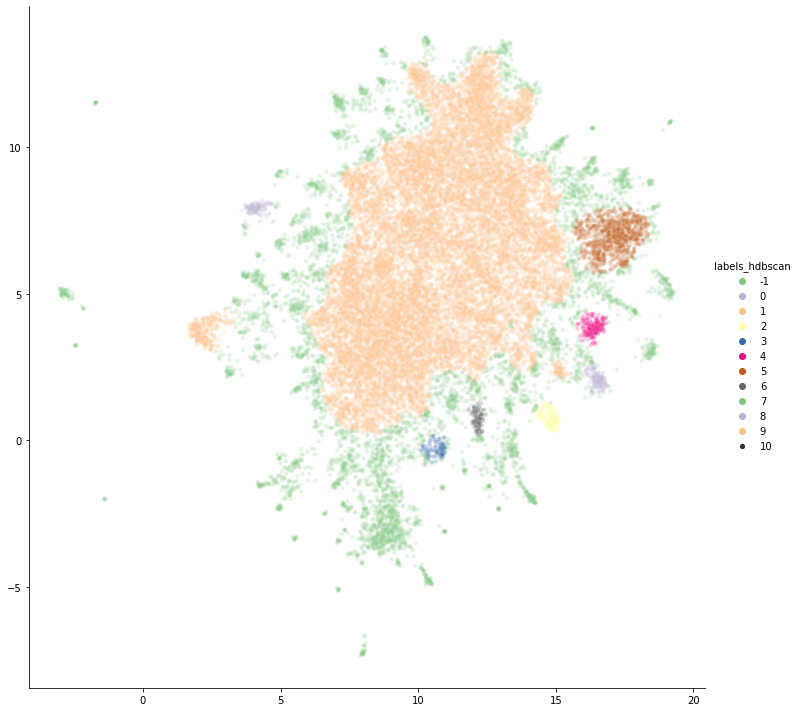

In [46]:
import seaborn as sns

palette_param = "Accent"
alpha_param = 0.2


sns.relplot(x = embeddings_umap2[:, 0], y = embeddings_umap2[:, 1], size = 10, hue = data["labels_hdbscan"], palette = palette_param,alpha = alpha_param,height = 10)


## Clustering with Kmedoids

In [36]:
from sklearn_extra.cluster import KMedoids

n_clusters = 20
init = 'k-medoids++'
km_clustering = KMedoids(n_clusters=n_clusters, metric='cosine', init=init, max_iter=150, random_state=None).fit(embeddings_umap2)

km_clustering

KMedoids(init='k-medoids++', max_iter=150, metric='cosine', n_clusters=20)

In [39]:
labels = km_clustering.labels_

labels

array([ 1, 18,  8, ...,  2, 17, 10])

In [44]:
data["label_kmedoids"] = labels
print("cluster","members\n", data["label_kmedoids"].value_counts().sort_values())

cluster members
 19       5
4       12
16      18
6      146
13     226
11     541
0      582
15    1011
3     1158
9     1292
7     1341
17    1638
2     1801
12    1863
18    2024
5     2092
8     2415
1     2537
10    2597
14    2615
Name: label_kmedoids, dtype: int64


/usr/local/lib/python3.8/site-packages/sklearn_extra/cluster/_k_medoids.py:199: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


n_iterations: 1 inertia: 0.31309205
n_iterations: 101 inertia: 0.2919135
n_iterations: 201 inertia: 0.2919135
n_iterations: 301 inertia: 0.2919135
n_iterations: 401 inertia: 0.2919135
n_iterations: 501 inertia: 0.2919135
n_iterations: 601 inertia: 0.2919135
n_iterations: 701 inertia: 0.2919135
n_iterations: 801 inertia: 0.2919135
n_iterations: 901 inertia: 0.2919135


<AxesSubplot:>

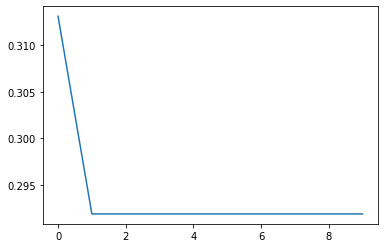

In [47]:
inertias = []
n_iterations = []
init_param = init
random_state_param=1234
for i in range(1,1001,100):
    inertia = KMedoids(n_clusters=100, metric='cosine', init=init, max_iter=i, random_state=random_state_param).fit(embeddings_umap2).inertia_
    print("n_iterations:",i, "inertia:",inertia)
    inertias.append(inertia)
    n_iterations.append(i)
sns.lineplot(data=inertias)

In [49]:
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_samples, silhouette_score

kmedoids_sse_svd, kmedoids_slc_svd = {}, {}
for k in range(5, 105, 5):
    kmedoids_svd = KMedoids(n_clusters = k, metric='cosine', max_iter = 100, init=init).fit(embeddings_umap2)
    kmedoids_clusters_svd = kmedoids_svd.labels_
    kmedoids_sse_svd[k] = kmedoids_svd.inertia_
    kmedoids_slc_svd[k] = silhouette_score(X_svd, kmedoids_clusters_svd)

In [34]:
kmedoids_sse_svd

{60: 20009.861, 70: 19680.549, 80: 19467.701}

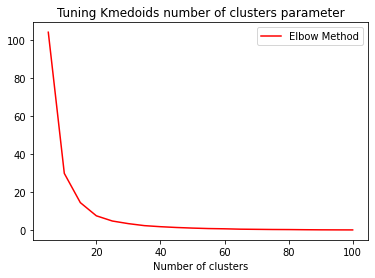

In [61]:
plt.plot(list(kmedoids_sse_svd.keys()), list(kmedoids_sse_svd.values()), color="red", label="Elbow Method")

plt.title("Tuning Kmedoids number of clusters parameter")
plt.xlabel("Number of clusters")
plt.legend(loc="upper right")
plt.show()

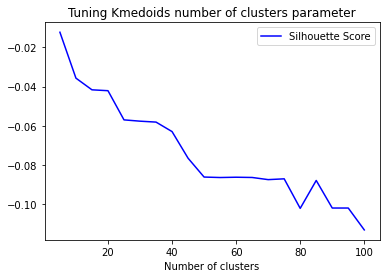

In [60]:
plt.plot(list(kmedoids_slc_svd.keys()), list(kmedoids_slc_svd.values()), color="blue", label="Silhouette Score")
plt.title("Tuning Kmedoids number of clusters parameter")
plt.xlabel("Number of clusters")
plt.legend(loc="upper right")
plt.show()

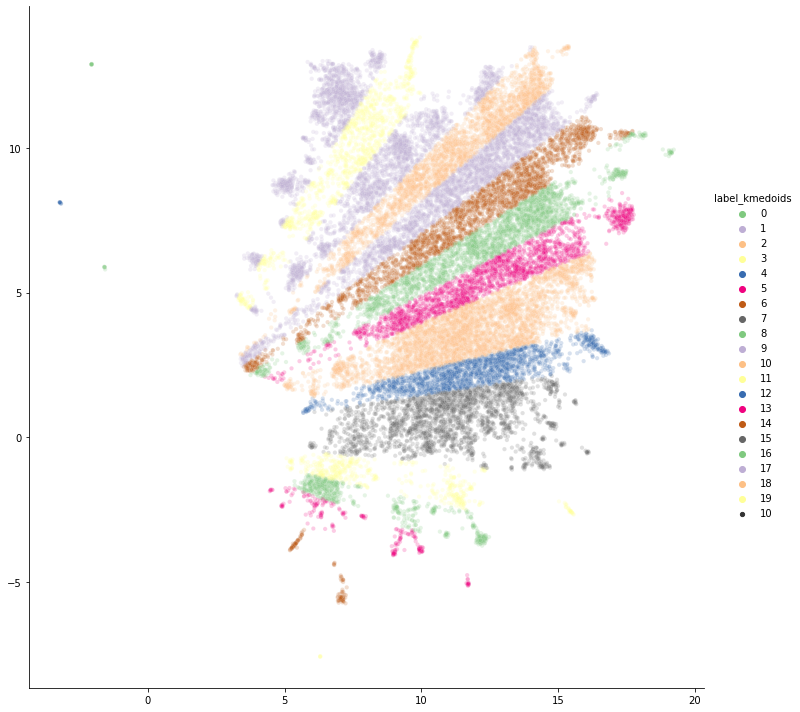

In [63]:
palette_param = "Accent"
alpha_param = 0.2


sns.relplot(x = embeddings_umap2[:, 0], y = embeddings_umap2[:, 1], size = 10, hue = data["label_kmedoids"], palette = palette_param,alpha = alpha_param,height = 10)


## Agglomerative Clustering

In [66]:
embeddings_umap2

array([[13.216024 ,  9.8381   ],
       [ 7.8270774,  2.5114973],
       [17.322783 ,  9.150346 ],
       ...,
       [ 7.857053 ,  2.2586124],
       [ 9.262685 ,  9.869091 ],
       [11.727439 ,  9.661802 ]], dtype=float32)

In [16]:
from sklearn.cluster import AgglomerativeClustering, DBSCAN
number_of_clusters =  20

labels = AgglomerativeClustering(n_clusters = number_of_clusters).fit(embeddings_tsne).labels_

In [17]:
data["label_agglomerative"] = labels
data["label_agglomerative"] = data["label_agglomerative"].astype('category')

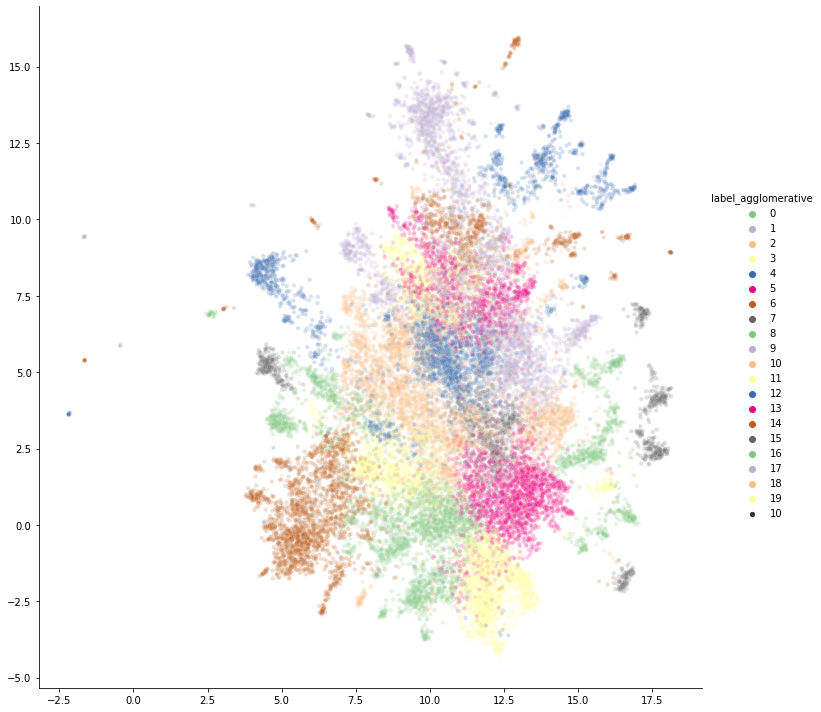

In [18]:
import seaborn as sns
palette_param = "Accent"
alpha_param = 0.2


sns.relplot(x = embeddings_umap2[:, 0], y = embeddings_umap2[:, 1], size = 10, hue = data["label_agglomerative"], palette = palette_param,alpha = alpha_param,height = 10)
